In [76]:
%matplotlib inline

from glob              import glob
from matplotlib        import pyplot as plt
from matplotlib.ticker import NullFormatter
from re                import findall

In [77]:
BLEU_EPOCHS = [0,2,4,6,8,10,12,14,15]
PPLX_EPOCHS = range(0,15)

In [78]:
def read_bleu_pplx(patn):
    data = {}
    for output_path in glob(patn):
        with open(output_path, 'r') as output_file:
            output_contents = output_file.read()
            bleu_scores = map(float,findall(r'BLEU: (\d+\.\d+)', output_contents))
            bleu_scores = list(zip(BLEU_EPOCHS, bleu_scores))
            pplx_scores = map(float,findall(r'dev perplexity \| (\d+\.\d+)', output_contents))
            pplx_scores = list(zip(PPLX_EPOCHS, pplx_scores))
            data[output_path] = {'bleu': bleu_scores, 'pplx': pplx_scores}
    return data

In [79]:
def plot_bleu_pplx(data,name,words_in_dev,baseline_bleu,baseline_pplx):
    
    plt.figure(1, figsize=(8,8))
    
    bleu = plt.axes([0.0, 0.52, 0.8, 0.49])
    pplx = plt.axes([0.0, 0.0 , 0.8, 0.49])

    for key, val in data.items():
        epoch, bleu_score = zip(*val['bleu'])
        epoch = [e + 1 for e in epoch]
        bleu.plot(epoch, bleu_score, label=key)
        epoch, pplx_score = zip(*val['pplx'])
        epoch = [e + 1 for e in epoch]
        pplx.plot(epoch, pplx_score, label=key)

    def keep_lim(ax, func):
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        func(ax)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    
    keep_lim(bleu, lambda ax: ax.scatter([10], [baseline_bleu], label='output/base0.output'))
    keep_lim(pplx, lambda ax: ax.scatter([10], [baseline_pplx], label='output/base0.output'))

    nullfmt = NullFormatter()
    bleu.xaxis.set_major_formatter(nullfmt)
    bleu.set_ylabel('BLEU')
    pplx.set_ylabel('Perplexity ({} words)'.format(words_in_dev))
    pplx.set_xlabel('# Epochs')

    handles, labels = bleu.get_legend_handles_labels()
    handles, labels = zip(*map(lambda t: (t[0], name[t[1]]),sorted(zip(handles, labels), key=lambda t: t[1])))
    bleu.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

    plt.show()

In [80]:
IN_BASELINE_BLEU = _
IN_BASELINE_PPLX = _
IN_WORDS_IN_DEV  = 3331

IN_NAME = {"output/{}.output".format(k):v for k,v in {
       'base0': 'baseline (0)',
    'in_base1': 'baseline (1)'
}.items()}

plot_bleu_pplx(read_bleu_pplx('output/in_*.output'), 
               name=IN_NAME, 
               words_in_dev=IN_WORDS_IN_DEV, 
               baseline_bleu=IN_BASELINE_BLEU,
               baseline_pplx=IN_BASELINE_PPLX)

ValueError: could not convert string to float: 

ValueError: could not convert string to float: 

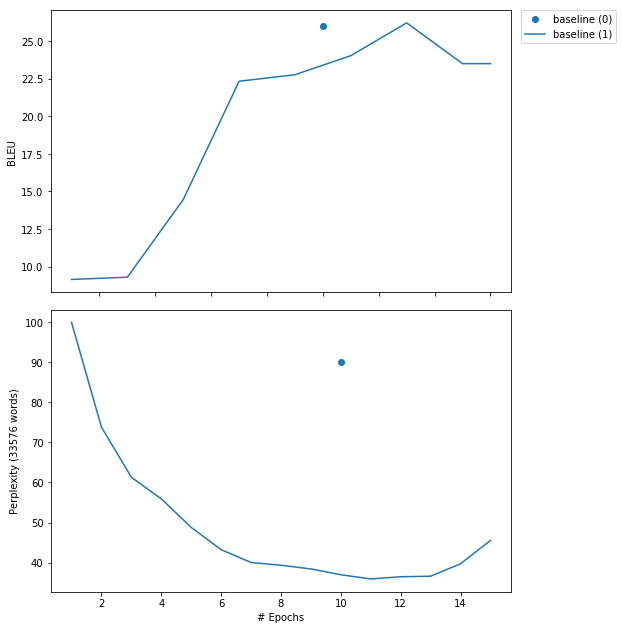

In [81]:
HU_BASELINE_BLEU = 26.03
HU_BASELINE_PPLX = 90.104580
HU_WORDS_IN_DEV  = 33576

HU_NAME = {"output/{}.output".format(k):v for k,v in {
       'base0': 'baseline (0)',
    'hu_base1': 'baseline (1)'
}.items()}

plot_bleu_pplx(read_bleu_pplx('output/hu_*.output'), 
               name=HU_NAME, 
               words_in_dev=HU_WORDS_IN_DEV, 
               baseline_bleu=HU_BASELINE_BLEU,
               baseline_pplx=HU_BASELINE_PPLX)